In [ ]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import random
from jaxtyping import Array, Float

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jaxtyping extension is already loaded. To reload it, use:
  %reload_ext jaxtyping


In [13]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str

mdata = sm.datasets.macrodata.load_pandas().data

# prepare the dates index
dates = mdata[["year", "quarter"]].astype(int).astype(str)

quarterly = dates["year"] + "Q" + dates["quarter"]

quarterly = dates_from_str(quarterly)

mdata = mdata[["realgdp", "realcons", "realinv"]]

mdata.index = pd.DatetimeIndex(quarterly, freq="QE")

data = np.log(mdata).diff().dropna()

data.head()

,realgdp,realcons,realinv
1959-06-30,0.024942,0.015286,0.080213
1959-09-30,-0.001193,0.010386,-0.072131
1959-12-31,0.003495,0.001084,0.034425
1960-03-31,0.022190,0.009534,0.102664
1960-06-30,-0.004685,0.012572,-0.106694


In [16]:
var_model = VAR(data)

var_results = var_model.fit(maxlags=2)

var_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 01, Oct, 2025
Time:                     17:46:53
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001527         0.001119            1.365           0.172
L1.realgdp         -0.279435         0.169663           -1.647           0.100
L1.realcons         0.675016         0.131285            5.142    

In [23]:
y: Float[Array, "time vars"] = jnp.array(data)

In [29]:
def model(y: Float[Array, "time vars"], n_lags: int):
    n_time, n_vars = y.shape
    n_coefs = n_vars * n_lags

    with numpyro.plate("constants", n_vars):
        constant = numpyro.sample("constant", dist.Normal(0, 1))

        sigma = numpyro.sample("sigma", dist.HalfNormal(1.0))

        l_omega = numpyro.sample(
            "L_omega", dist.LKJCholesky(dimension=n_vars, concentration=1.0)
        )
        l_sigma = sigma[..., None] * l_omega

    with numpyro.plate("lags", n_lags):
        phi = numpyro.sample(
            "phi", dist.Normal(0, 1).expand([n_vars, n_vars]).to_event(2)
        )

    print(phi.shape)

    def transition(carry, t):
        y_prev = carry
        m_t = constant + jnp.dot(phi, y_prev)
        y_t = numpyro.sample(
            f"y_{t}",
            dist.MultivariateNormal(loc=m_t, scale_tril=l_sigma),
            obs=y[t],
        )
        return y_t, y_t


(2, 3, 3)
(2, 3, 3)


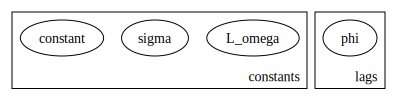

In [30]:
numpyro.render_model(model, model_kwargs={"y": y, "n_lags": 2})

In [28]:
y[0]

Array([0.02494213, 0.01528611, 0.08021268], dtype=float32)